In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/salecars/Car_sales.csv


## To predict Sales of cars.

In [2]:
#packages for basic analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#packages for ML/Stats
import scipy.stats as stats
import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, f_regression, SelectKBest,f_oneway
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [4]:
#read the data
cars=pd.read_csv('../input/salecars/Car_sales.csv')

In [5]:
cars.head(2)

,Manufacturer,Model,Sales_in_thousands,four_year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.5,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.4,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778


In [6]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
Manufacturer              157 non-null object
Model                     157 non-null object
Sales_in_thousands        157 non-null float64
four_year_resale_value    121 non-null float64
Vehicle_type              157 non-null object
Price_in_thousands        155 non-null float64
Engine_size               156 non-null float64
Horsepower                156 non-null float64
Wheelbase                 156 non-null float64
Width                     156 non-null float64
Length                    156 non-null float64
Curb_weight               155 non-null float64
Fuel_capacity             156 non-null float64
Fuel_efficiency           154 non-null float64
Latest_Launch             157 non-null object
Power_perf_factor         155 non-null float64
dtypes: float64(12), object(4)
memory usage: 19.8+ KB


In [7]:
#separating categorical and numerical features
cars_con=cars.select_dtypes(exclude='object')
cars_cat=cars.select_dtypes(include='object')

In [8]:
print(cars_con.columns)
print(cars_cat.columns)

Index(['Sales_in_thousands', 'four_year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length',
       'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor'],
      dtype='object')
Index(['Manufacturer', 'Model', 'Vehicle_type', 'Latest_Launch'], dtype='object')


## Pre-modelling steps

### 1. UDFs

In [9]:
# descriptive stats for conti vars.
def con_stats(x):
    return pd.Series({'Count':x.count(),'NaNs':x.isnull().sum(),'Sum':x.sum(),'Mean':x.mean(),'Std_dev':x.std(),'Coef_var':(x.std()/x.mean()),'Min':x.min(),
                     'P1':x.quantile(0.01),'P5':x.quantile(0.05),'P10':x.quantile(0.10),'P25':x.quantile(0.25),'P50':x.quantile(0.5),'P90':x.quantile(0.9),
                      'P99':x.quantile(0.99),'Max':x.max()})

In [10]:
# descriptive stats for categorical vars.
def cat_stats(x):
    mo=x.value_counts().sort_values(ascending=False).index[0]  #mode/value with highest count   # can also use .mode() func
    mo_freq=x.value_counts().sort_values(ascending=False)[0]   #count/freq of mode
    return pd.Series({'Count':x.count(),'NaNs':x.isnull().sum(),'Uniques':x.value_counts().count(),'Mode':mo,'Mode_freq':mo_freq})

In [11]:
# missing value treatment
def mis(x):
    if ((x.dtype=='float64')|( x.dtype=='int64')):
        x.fillna(x.mean(),inplace=True)
    else:
        x.fillna(x.mode()[0],inplace=True)
    return x

In [12]:
# outlier treatment
def outs(x):
    x.clip(lower=x.quantile(0.01),upper=x.quantile(0.99),inplace=True)
    return x

In [13]:
# dummy var creation
def dums(df):
    df=pd.get_dummies(df,prefix='Dum',drop_first=True)
    return df

In [14]:
#descrptive stats
cars_con.apply(con_stats).T.round(2)

,Count,NaNs,Sum,Mean,Std_dev,Coef_var,Min,P1,P5,P10,P25,P50,P90,P99,Max
Sales_in_thousands,157.0,0.0,8320.70,53.00,68.03,1.28,0.11,0.94,1.87,5.45,14.11,29.45,127.64,260.65,540.56
four_year_resale_value,121.0,36.0,2186.83,18.07,11.45,0.63,5.16,6.17,7.85,9.12,11.26,14.18,32.08,60.22,67.55
Price_in_thousands,155.0,2.0,4245.57,27.39,14.35,0.52,9.24,10.23,12.47,13.97,18.02,22.80,44.02,78.48,85.50
Engine_size,156.0,1.0,477.50,3.06,1.04,0.34,1.00,1.56,1.80,1.95,2.30,3.00,4.60,5.70,8.00
Horsepower,156.0,1.0,29008.00,185.95,56.70,0.30,55.00,96.40,114.50,120.00,149.50,177.50,254.00,325.75,450.00
Wheelbase,156.0,1.0,16768.00,107.49,7.64,0.07,92.60,92.88,95.87,98.65,103.00,107.00,115.50,134.37,138.70
Width,156.0,1.0,11099.40,71.15,3.45,0.05,62.60,66.09,66.50,66.90,68.40,70.55,76.20,79.19,79.90
Length,156.0,1.0,29225.60,187.34,13.43,0.07,149.40,154.92,163.68,173.00,177.58,187.90,203.40,219.30,224.50
Curb_weight,155.0,2.0,523.59,3.38,0.63,0.19,1.90,2.25,2.42,2.61,2.97,3.34,4.12,5.40,5.57
Fuel_capacity,156.0,1.0,2800.50,17.95,3.89,0.22,10.30,11.90,12.50,13.20,15.80,17.20,23.20,30.90,32.00


In [15]:
#descrptive stats
cars_cat.apply(cat_stats).T

,Count,NaNs,Uniques,Mode,Mode_freq
Manufacturer,157,0,30,Ford,11
Model,157,0,156,Neon,2
Vehicle_type,157,0,2,Passenger,116
Latest_Launch,157,0,130,4/1/2011,2


#### Dropping 'Model' & 'Latest_Launch' since it has too many categoris + also, least important from business point of view

In [16]:
cars_cat.drop(columns=['Model','Latest_Launch'],inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
cars_cat.apply(cat_stats).T

,Count,NaNs,Uniques,Mode,Mode_freq
Manufacturer,157,0,30,Ford,11
Vehicle_type,157,0,2,Passenger,116


In [18]:
#missing value treatment
cars_con.apply(mis)
cars_cat.apply(mis)

,Manufacturer,Vehicle_type
0,Acura,Passenger
1,Acura,Passenger
2,Acura,Passenger
3,Acura,Passenger
4,Audi,Passenger
...,...,...
152,Volvo,Passenger
153,Volvo,Passenger
154,Volvo,Passenger
155,Volvo,Passenger


In [19]:
cars_con.isnull().any()

Sales_in_thousands        False
four_year_resale_value    False
Price_in_thousands        False
Engine_size               False
Horsepower                False
Wheelbase                 False
Width                     False
Length                    False
Curb_weight               False
Fuel_capacity             False
Fuel_efficiency           False
Power_perf_factor         False
dtype: bool

In [20]:
cars_cat.isnull().any()

Manufacturer    False
Vehicle_type    False
dtype: bool

In [21]:
#outlier treatment
cars_con.apply(outs)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
0,16.919,16.360000,21.500000,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,58.280150
1,39.384,19.875000,28.400000,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,91.370778
2,14.114,18.225000,27.390755,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,77.043591
3,8.588,29.725000,42.000000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,91.389779
4,20.397,22.255000,23.990000,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,62.777639
...,...,...,...,...,...,...,...,...,...,...,...,...
152,3.545,18.072975,24.400000,1.9,160.0,100.5,67.6,176.6,3.042,15.8,25.0,66.498812
153,15.245,18.072975,27.500000,2.4,168.0,104.9,69.3,185.9,3.208,17.9,25.0,70.654495
154,17.531,18.072975,28.800000,2.4,168.0,104.9,69.3,186.2,3.259,17.9,25.0,71.155978
155,3.493,18.072975,45.500000,2.3,236.0,104.9,71.5,185.7,3.601,18.5,23.0,101.623357


In [22]:
cars_con.apply(con_stats).T.round(2) #comparing this with earlier one, we see outliers have been clipped

,Count,NaNs,Sum,Mean,Std_dev,Coef_var,Min,P1,P5,P10,P25,P50,P90,P99,Max
Sales_in_thousands,157.0,0.0,8025.53,51.12,57.72,1.13,0.94,0.95,1.87,5.45,14.11,29.45,127.64,253.56,260.65
four_year_resale_value,157.0,0.0,2830.72,18.03,9.76,0.54,6.74,7.12,8.42,9.71,12.54,17.71,27.02,58.99,59.49
Price_in_thousands,157.0,0.0,4290.47,27.33,13.97,0.51,10.25,10.49,12.49,13.98,18.14,23.40,43.79,76.45,78.33
Engine_size,157.0,0.0,478.87,3.05,0.98,0.32,1.56,1.58,1.80,1.96,2.30,3.00,4.60,5.70,5.70
Horsepower,157.0,0.0,29095.71,185.32,52.63,0.28,96.48,98.45,114.60,120.00,150.00,180.00,253.80,316.78,325.40
Wheelbase,157.0,0.0,16867.45,107.44,7.40,0.07,92.88,93.00,95.92,98.70,103.00,107.00,115.46,132.45,134.30
Width,157.0,0.0,11173.61,71.17,3.38,0.05,66.09,66.26,66.50,66.90,68.40,70.60,76.18,79.14,79.19
Length,157.0,0.0,29411.21,187.33,13.07,0.07,154.97,156.27,163.70,173.12,177.60,187.80,203.34,217.02,219.22
Curb_weight,157.0,0.0,530.53,3.38,0.62,0.18,2.25,2.25,2.42,2.61,2.98,3.37,4.12,5.39,5.40
Fuel_capacity,157.0,0.0,2817.81,17.95,3.81,0.21,11.90,11.90,12.50,13.20,15.80,17.20,23.20,30.39,30.88


In [23]:
#dummy var creation
cars_cat=dums(cars_cat)

In [24]:
cars_cat.head(2)

,Dum_Audi,Dum_BMW,Dum_Buick,Dum_Cadillac,Dum_Chevrolet,Dum_Chrysler,Dum_Dodge,Dum_Ford,Dum_Honda,Dum_Hyundai,...,Dum_Plymouth,Dum_Pontiac,Dum_Porsche,Dum_Saab,Dum_Saturn,Dum_Subaru,Dum_Toyota,Dum_Volkswagen,Dum_Volvo,Dum_Passenger
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
#combining the datasets
cars_final=pd.concat([cars_con,cars_cat],axis=1)
cars_final.head(2)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Dum_Plymouth,Dum_Pontiac,Dum_Porsche,Dum_Saab,Dum_Saturn,Dum_Subaru,Dum_Toyota,Dum_Volkswagen,Dum_Volvo,Dum_Passenger
0,16.919,16.360,21.5,1.8,140.0,101.2,67.3,172.4,2.639,13.2,...,0,0,0,0,0,0,0,0,0,1
1,39.384,19.875,28.4,3.2,225.0,108.1,70.3,192.9,3.517,17.2,...,0,0,0,0,0,0,0,0,0,1


In [26]:
cars_final.columns

Index(['Sales_in_thousands', 'four_year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length',
       'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor',
       'Dum_Audi', 'Dum_BMW', 'Dum_Buick', 'Dum_Cadillac', 'Dum_Chevrolet',
       'Dum_Chrysler', 'Dum_Dodge', 'Dum_Ford', 'Dum_Honda', 'Dum_Hyundai',
       'Dum_Infiniti', 'Dum_Jaguar', 'Dum_Jeep', 'Dum_Lexus', 'Dum_Lincoln',
       'Dum_Mercedes-B', 'Dum_Mercury', 'Dum_Mitsubishi', 'Dum_Nissan',
       'Dum_Oldsmobile', 'Dum_Plymouth', 'Dum_Pontiac', 'Dum_Porsche',
       'Dum_Saab', 'Dum_Saturn', 'Dum_Subaru', 'Dum_Toyota', 'Dum_Volkswagen',
       'Dum_Volvo', 'Dum_Passenger'],
      dtype='object')

## Essential Assumptions check

Skewness : 1.9734059838643523


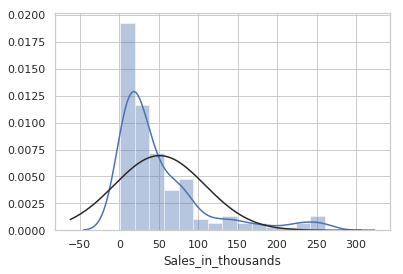

In [27]:
#normality of Y
sns.set(style='whitegrid')
sns.distplot(cars_final['Sales_in_thousands'],fit=stats.norm)
print('Skewness :',stats.skew(cars_final['Sales_in_thousands']))

Inference from the plot :
* Target var. is not normally distributed
* Skewness is 1.9, which is very high
* Hence applying log transformation

In [28]:
cars_final['ln_Sales_in_thousands']=np.log(cars_final['Sales_in_thousands'])

Skewness post transform : -0.5869093663686262


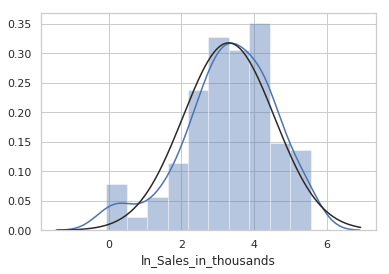

In [29]:
sns.distplot(cars_final['ln_Sales_in_thousands'],fit=stats.norm)
print('Skewness post transform :',stats.skew(cars_final['ln_Sales_in_thousands']))

* Skewess within acceptable range
* Distribution near normal post transformation

In [30]:
# checking relation of each var. with transformed target--> ln_sales_in_thousands
corseries=cars_final.corrwith(cars_final['ln_Sales_in_thousands'])
corseries

Sales_in_thousands        0.799513
four_year_resale_value   -0.479862
Price_in_thousands       -0.578173
Engine_size              -0.120947
Horsepower               -0.400462
Wheelbase                 0.270114
Width                     0.038288
Length                    0.207158
Curb_weight              -0.051903
Fuel_capacity            -0.019541
Fuel_efficiency           0.135225
Power_perf_factor        -0.447172
Dum_Audi                 -0.134931
Dum_BMW                  -0.068309
Dum_Buick                 0.087507
Dum_Cadillac             -0.075474
Dum_Chevrolet             0.098202
Dum_Chrysler             -0.016323
Dum_Dodge                 0.087912
Dum_Ford                  0.345869
Dum_Honda                 0.155728
Dum_Hyundai               0.051359
Dum_Infiniti             -0.008834
Dum_Jaguar               -0.036066
Dum_Jeep                  0.131423
Dum_Lexus                -0.129608
Dum_Lincoln              -0.009894
Dum_Mercedes-B           -0.244774
Dum_Mercury         

In [31]:
#checking vars where, correlation is more than 0.1
np.abs(corseries)>0.1

Sales_in_thousands         True
four_year_resale_value     True
Price_in_thousands         True
Engine_size                True
Horsepower                 True
Wheelbase                  True
Width                     False
Length                     True
Curb_weight               False
Fuel_capacity             False
Fuel_efficiency            True
Power_perf_factor          True
Dum_Audi                   True
Dum_BMW                   False
Dum_Buick                 False
Dum_Cadillac              False
Dum_Chevrolet             False
Dum_Chrysler              False
Dum_Dodge                 False
Dum_Ford                   True
Dum_Honda                  True
Dum_Hyundai               False
Dum_Infiniti              False
Dum_Jaguar                False
Dum_Jeep                   True
Dum_Lexus                  True
Dum_Lincoln               False
Dum_Mercedes-B             True
Dum_Mercury               False
Dum_Mitsubishi             True
Dum_Nissan                 True
Dum_Olds

In [32]:
# taking only those, where correlation is more than 0.1
high_cor_cols=corseries[np.abs(corseries)>0.1].index
high_cor_cols

Index(['Sales_in_thousands', 'four_year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Length', 'Fuel_efficiency',
       'Power_perf_factor', 'Dum_Audi', 'Dum_Ford', 'Dum_Honda', 'Dum_Jeep',
       'Dum_Lexus', 'Dum_Mercedes-B', 'Dum_Mitsubishi', 'Dum_Nissan',
       'Dum_Plymouth', 'Dum_Porsche', 'Dum_Toyota', 'Dum_Volvo',
       'Dum_Passenger', 'ln_Sales_in_thousands'],
      dtype='object')

In [33]:
cars_final=cars_final[high_cor_cols]
cars_final.head(2)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Length,Fuel_efficiency,Power_perf_factor,Dum_Audi,...,Dum_Lexus,Dum_Mercedes-B,Dum_Mitsubishi,Dum_Nissan,Dum_Plymouth,Dum_Porsche,Dum_Toyota,Dum_Volvo,Dum_Passenger,ln_Sales_in_thousands
0,16.919,16.360,21.5,1.8,140.0,101.2,172.4,28.0,58.280150,0,...,0,0,0,0,0,0,0,0,1,2.828437
1,39.384,19.875,28.4,3.2,225.0,108.1,192.9,25.0,91.370778,0,...,0,0,0,0,0,0,0,0,1,3.673360


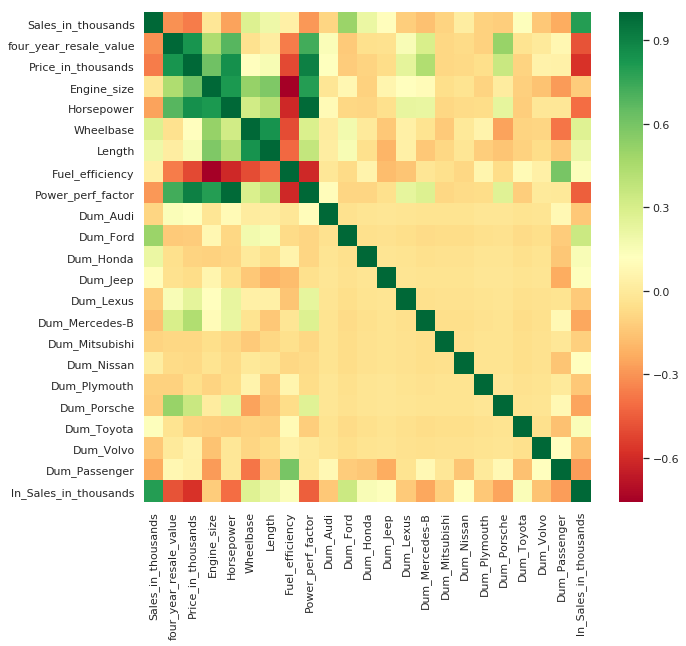

In [34]:
# multi-collinearity check
plt.figure(figsize=(10,9))
sns.heatmap(cars_final.corr(),cmap='RdYlGn')

* Shades of yellow signifies low correlation, since most part of the heatmap is yellow, multi-correlation among vars is less.
* The area in top left corner indicates variables with multi-collinearity since the shades of colors are near green & red.
* Taking note of correlated vars :
    * 'Fuel_efficiency' variable is  highly correlated with other vars.
    * 'Horsepower' too.
    * 'Power_perf_factor' to some extent.
    * 'four_year_resale_value' also

## Feature Reduction

In [35]:
#removing trget vars before feature reduction reduction from
feature_cols=cars_final.columns.difference(['Sales_in_thousands','ln_Sales_in_thousands'])
feature_cols

Index(['Dum_Audi', 'Dum_Ford', 'Dum_Honda', 'Dum_Jeep', 'Dum_Lexus',
       'Dum_Mercedes-B', 'Dum_Mitsubishi', 'Dum_Nissan', 'Dum_Passenger',
       'Dum_Plymouth', 'Dum_Porsche', 'Dum_Toyota', 'Dum_Volvo', 'Engine_size',
       'Fuel_efficiency', 'Horsepower', 'Length', 'Power_perf_factor',
       'Price_in_thousands', 'Wheelbase', 'four_year_resale_value'],
      dtype='object')

In [36]:
#creating X(feature) and y(target) dataframes
X=cars_final[feature_cols]
y=cars_final['ln_Sales_in_thousands']

In [37]:
# using f-regression
F_score,p_value = f_regression(X,y)

In [38]:
f_reg_results=pd.DataFrame({'Features':X.columns,'F-Scores':F_score,'p-Values':p_value.round(3)})
f_reg_results.sort_values(by='F-Scores',ascending=False)

,Features,F-Scores,p-Values
18,Price_in_thousands,77.832202,0.000
20,four_year_resale_value,46.368650,0.000
17,Power_perf_factor,38.740911,0.000
15,Horsepower,29.605047,0.000
1,Dum_Ford,21.061447,0.000
8,Dum_Passenger,12.462157,0.001
19,Wheelbase,12.199067,0.001
10,Dum_Porsche,10.653178,0.001
5,Dum_Mercedes-B,9.878573,0.002
16,Length,6.949996,0.009


In [39]:
# VIF check for multi-collinearity
VIF=[]
for i in range(X.shape[1]):
    VIF.append(variance_inflation_factor(X.values,i))

In [40]:
VIF_df=pd.DataFrame({'Features':X.columns,'VIF':np.array(VIF)})
VIF_df.sort_values(by='VIF',ascending=False)

,Features,VIF
17,Power_perf_factor,4124.420708
15,Horsepower,2976.221978
16,Length,1282.188928
19,Wheelbase,1139.702245
18,Price_in_thousands,140.272838
14,Fuel_efficiency,102.271370
13,Engine_size,82.339068
20,four_year_resale_value,18.628304
8,Dum_Passenger,12.439768
5,Dum_Mercedes-B,2.006100


In [41]:
# dropping vars based on F-score/p-value, their VIF and also based on their business significance
feature_cols_new=X.columns.difference(['Dum_Passenger','Dum_Volvo','Dum_Honda','Dum_Porsche','Dum_Toyota','Dum_Mercedes-B','four_year_resale_value','Horsepower','Power_perf_factor','Wheelbase','Engine_size','Dum_Audi','Length','Dum_Jeep','Dum_Lexus','Dum_Nissan','Dum_Mitsubishi'])
X_new=X[feature_cols_new]

In [42]:
X_new.columns

Index(['Dum_Ford', 'Dum_Plymouth', 'Fuel_efficiency', 'Price_in_thousands'], dtype='object')

In [43]:
# VIF check for multi-collinearity
VIF2=[]
for i in range(X_new.shape[1]):
    VIF2.append(variance_inflation_factor(X_new.values,i))

VIF2_df=pd.DataFrame({'Features':X_new.columns,'VIF':np.array(VIF2)})
VIF2_df.sort_values(by='VIF',ascending=False)

,Features,VIF
2,Fuel_efficiency,3.608808
3,Price_in_thousands,3.442407
0,Dum_Ford,1.072733
1,Dum_Plymouth,1.032927


The above features are within acceptable range of VIF, and shall be used to train our model, and predict later.

In [44]:
final_data=pd.concat([X_new,y],axis=1)
train,test=train_test_split(final_data,test_size=0.3,random_state=3994)

In [45]:
final_data.columns

Index(['Dum_Ford', 'Dum_Plymouth', 'Fuel_efficiency', 'Price_in_thousands',
       'ln_Sales_in_thousands'],
      dtype='object')

## Modelling & Prediction

In [46]:
reg_formula='ln_Sales_in_thousands'+'~'+'+'.join(train.columns.difference(['ln_Sales_in_thousands']))

In [47]:
reg_formula

'ln_Sales_in_thousands~Dum_Ford+Dum_Plymouth+Fuel_efficiency+Price_in_thousands'

In [48]:
lm=smf.ols(reg_formula,train)

In [49]:
lm=lm.fit()

In [50]:
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_Sales_in_thousands   R-squared:                       0.407
Model:                               OLS   Adj. R-squared:                  0.384
Method:                    Least Squares   F-statistic:                     17.83
Date:                   Sat, 19 Oct 2019   Prob (F-statistic):           3.58e-11
Time:                           04:48:28   Log-Likelihood:                -146.30
No. Observations:                    109   AIC:                             302.6
Df Residuals:                        104   BIC:                             316.1
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

In [51]:
train_pred=np.exp(lm.predict(train))
test_pred=np.exp(lm.predict(test))

In [52]:
train_y=np.exp(train['ln_Sales_in_thousands'])
test_y=np.exp(test['ln_Sales_in_thousands'])

In [53]:
# train data metrics
mape_train = np.mean(np.abs((train_pred-train_y)/(train_y)))
rmse_train = np.sqrt(np.mean(np.square((train_pred-train_y))))
corr_train = np.corrcoef(train_pred,train_y)[1][0]

In [54]:
#test data metrics
mape_test = np.mean(np.abs((test_pred-test_y)/(test_y)))
rmse_test = np.sqrt(np.mean(np.square((test_pred-test_y))))
corr_test = np.corrcoef(test_pred,test_y)[1][0]

In [55]:
print('MAPE_train :',mape_train,'|| MAPE_test :',mape_test)
print('RMSE_train :',rmse_train,'|| RMSE_test :',rmse_test)
print('Train_corr :',corr_train,'|| Test_corr :',corr_test)

MAPE_train : 1.1922936868043692 || MAPE_test : 1.262600455691524
RMSE_train : 46.80309010403424 || RMSE_test : 55.121509617200374
Train_corr : 0.6395890727732655 || Test_corr : 0.533180242368375


* The error metrics of train and test data are close to each other, acceptable.
* The correlation between the actual values of target and the predicted values is greater than 0.5, acceptable.

## Model Validation & Decile Analysis

In [56]:
#train_new=pd.concat([train_y,train_pred],axis=1)
#test_new=pd.concat([test_y,test_pred],axis=1)

In [57]:
train_new=pd.DataFrame({'Actual':train_y,'Predicted':train_pred})
train_new['Deciles']=pd.qcut(train_new['Predicted'],10,labels=False)

test_new=pd.DataFrame({'Actual':test_y,'Predicted':test_pred})
test_new['Deciles']=pd.qcut(test_new['Predicted'],10,labels=False)

In [58]:
train_new.groupby('Deciles').mean()

,Actual,Predicted
Deciles,,
0,7.600182,6.843978
1,22.212727,13.262589
2,22.286545,18.568910
3,27.660000,24.353169
4,27.891727,27.646933
5,47.672300,30.367437
6,73.519844,33.146292
7,51.183545,35.100140
8,61.004909,39.589738


In [59]:
test_new.groupby('Deciles').mean()

,Actual,Predicted
Deciles,,
0,7.449656,4.857670
1,11.057800,10.951792
2,21.893600,19.796057
3,55.245750,22.629564
4,61.664800,26.313233
5,79.943600,28.700260
6,56.678750,30.979981
7,105.423600,36.367684
8,52.378800,47.141827


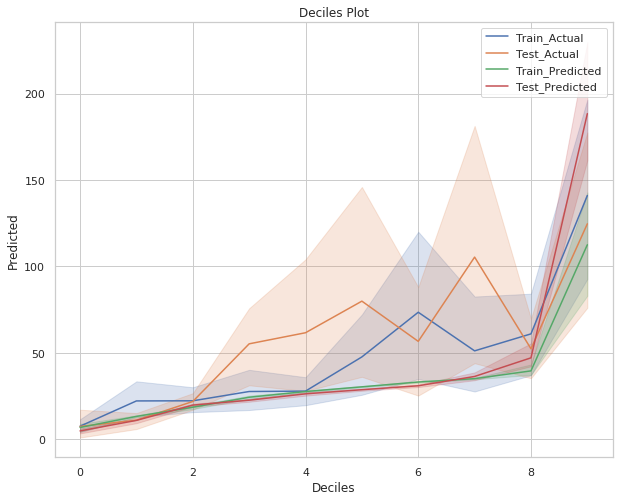

In [94]:
plt.figure(figsize=(10,8))
plt.title('Deciles Plot')
sns.lineplot(x=train_new['Deciles'],y=train_new['Actual'],label='Train_Actual')
sns.lineplot(x=test_new['Deciles'],y=test_new['Actual'],label='Test_Actual')
sns.lineplot(x=train_new['Deciles'],y=train_new['Predicted'],label='Train_Predicted')
sns.lineplot(x=test_new['Deciles'],y=test_new['Predicted'],label='Test_Predicted')

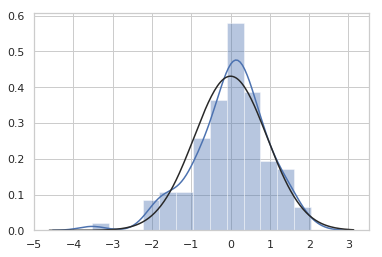

In [60]:
#distribution of residuals
sns.distplot(lm.resid,fit=stats.norm)

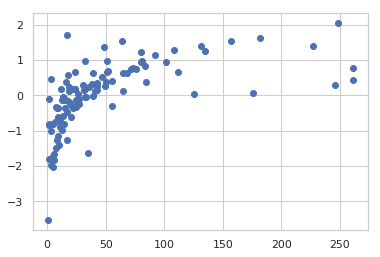

In [61]:
#actual and residual scatter
plt.scatter(train_y,lm.resid)

~END~